In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("diabetes.csv")

In [37]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### EDA (Exploratory Data Analysis)

-   Fill missing value
-   Remove outliers
-   Univariate Analysis
-   Multivariate Analysis


[Text(0, 0, '500'), Text(0, 0, '268')]

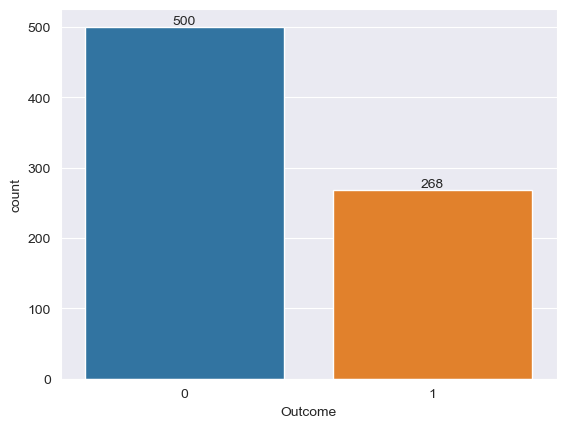

In [6]:
ax = sns.countplot(data=df, x="Outcome")
ax.bar_label(ax.containers[0])

In [40]:
# Kolom berikut memiliki missing value berupa nilai 0
missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

df[missing_cols] = df[missing_cols].replace(0, np.nan)

df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [42]:
for col in missing_cols:
    df[col] = df[col].fillna(df[col].mean())

df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [43]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

IQR

Pregnancies                  5.000000
Glucose                     40.500000
BloodPressure               16.000000
SkinThickness                7.000000
Insulin                     34.048223
BMI                          9.100000
DiabetesPedigreeFunction     0.382500
Age                         17.000000
Outcome                      1.000000
dtype: float64

In [48]:
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

df.shape

(515, 9)

array([[<AxesSubplot: title={'center': 'Pregnancies'}>,
        <AxesSubplot: title={'center': 'Glucose'}>,
        <AxesSubplot: title={'center': 'BloodPressure'}>],
       [<AxesSubplot: title={'center': 'SkinThickness'}>,
        <AxesSubplot: title={'center': 'Insulin'}>,
        <AxesSubplot: title={'center': 'BMI'}>],
       [<AxesSubplot: title={'center': 'DiabetesPedigreeFunction'}>,
        <AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'Outcome'}>]], dtype=object)

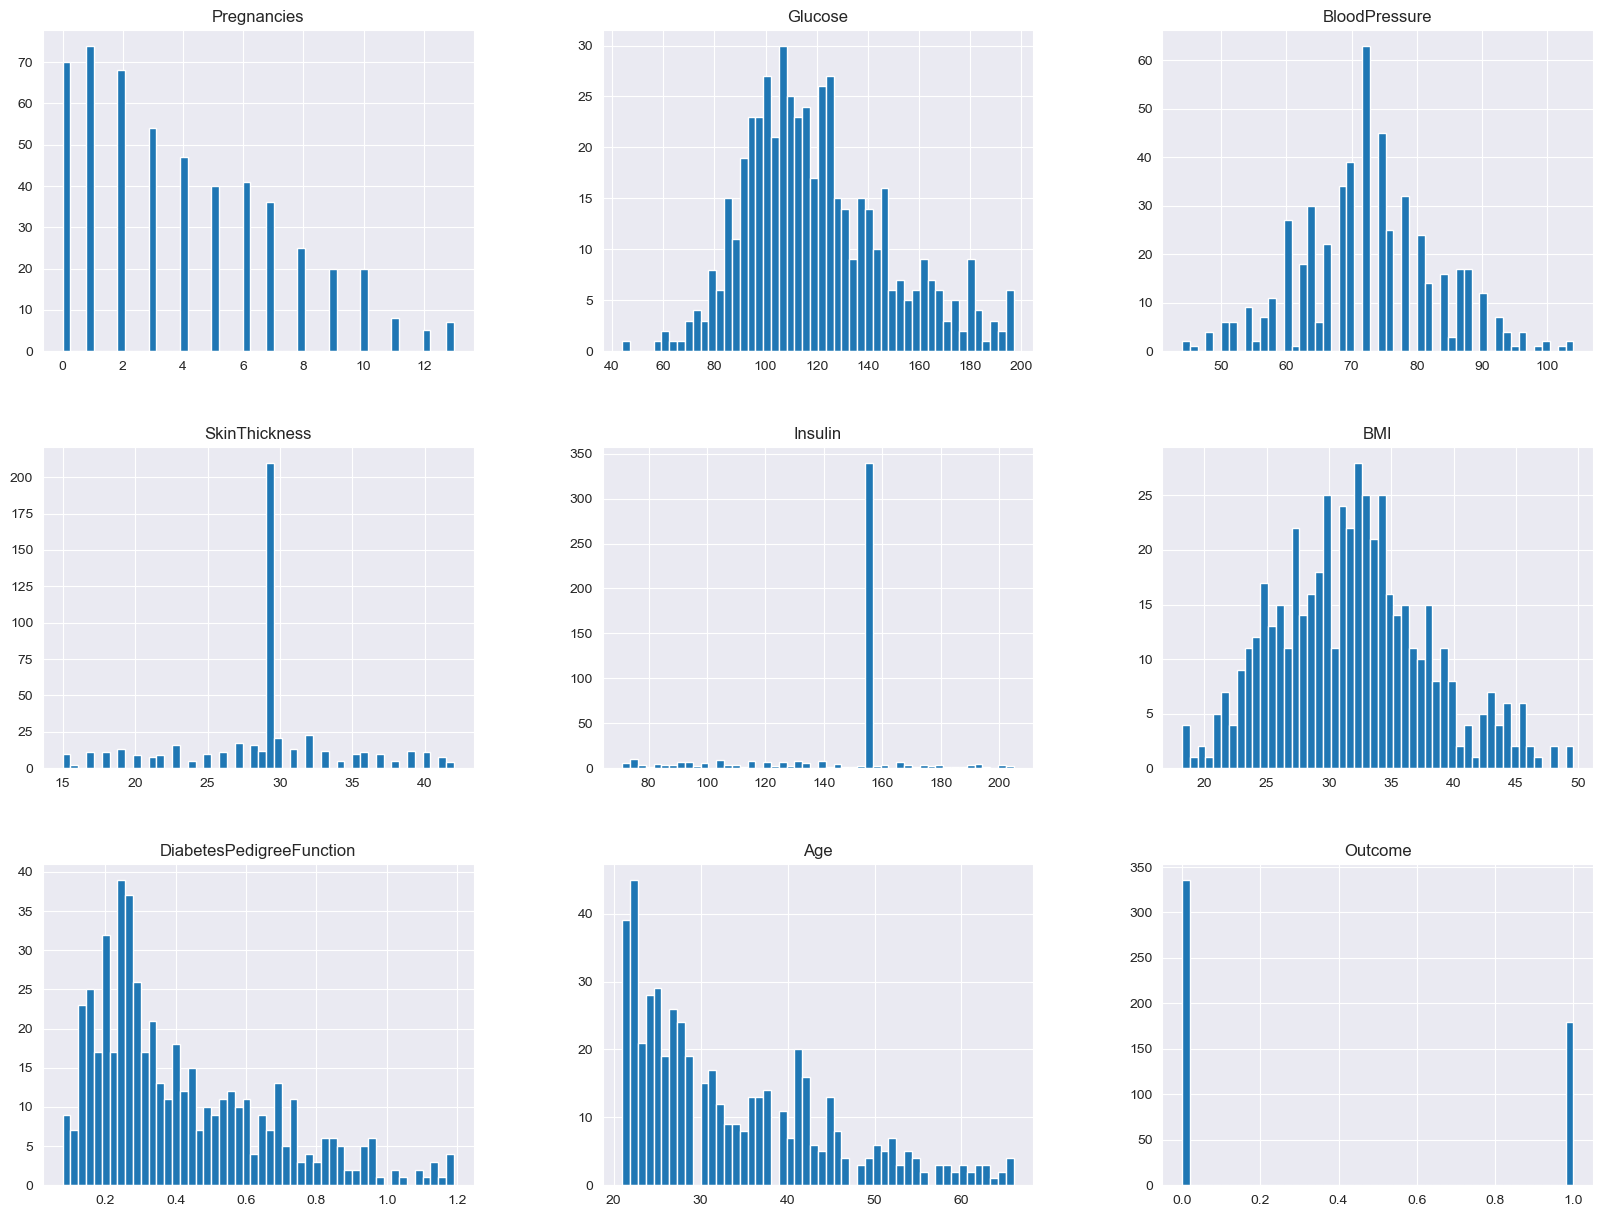

In [49]:
df.hist(bins=50, figsize=(20, 15))

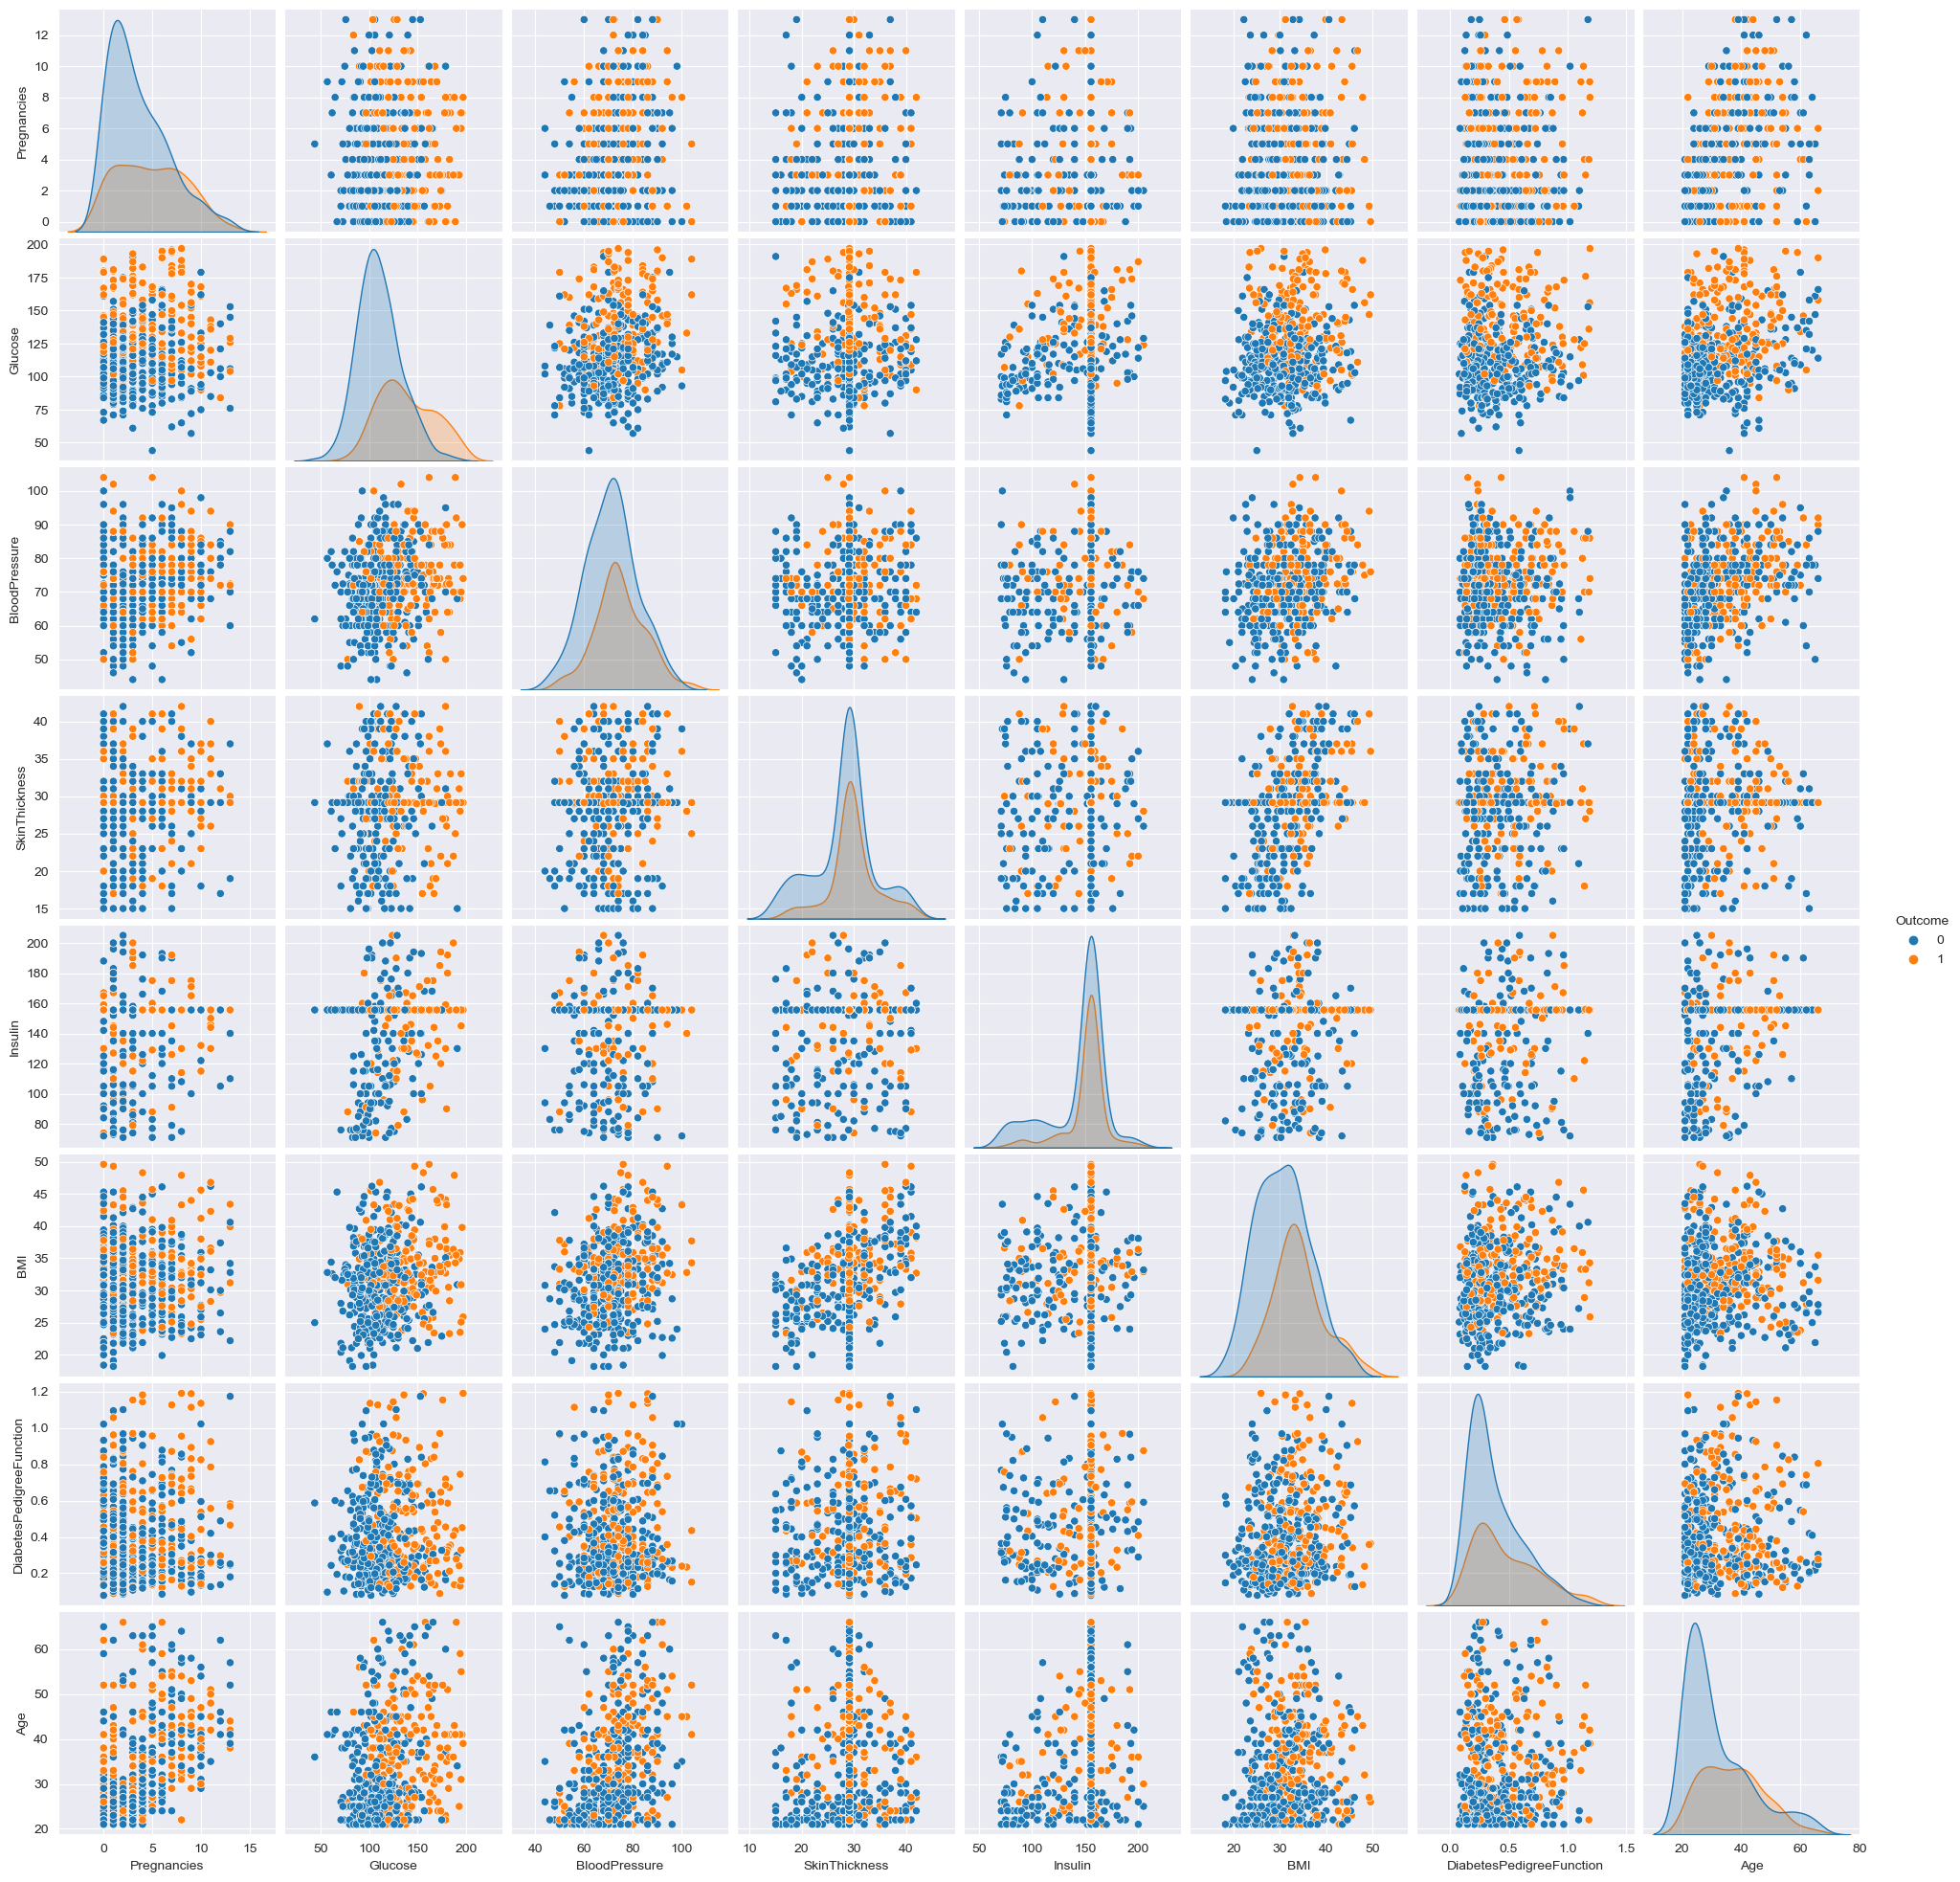

In [51]:
sns.pairplot(data=df, diag_kind="kde", hue="Outcome")

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

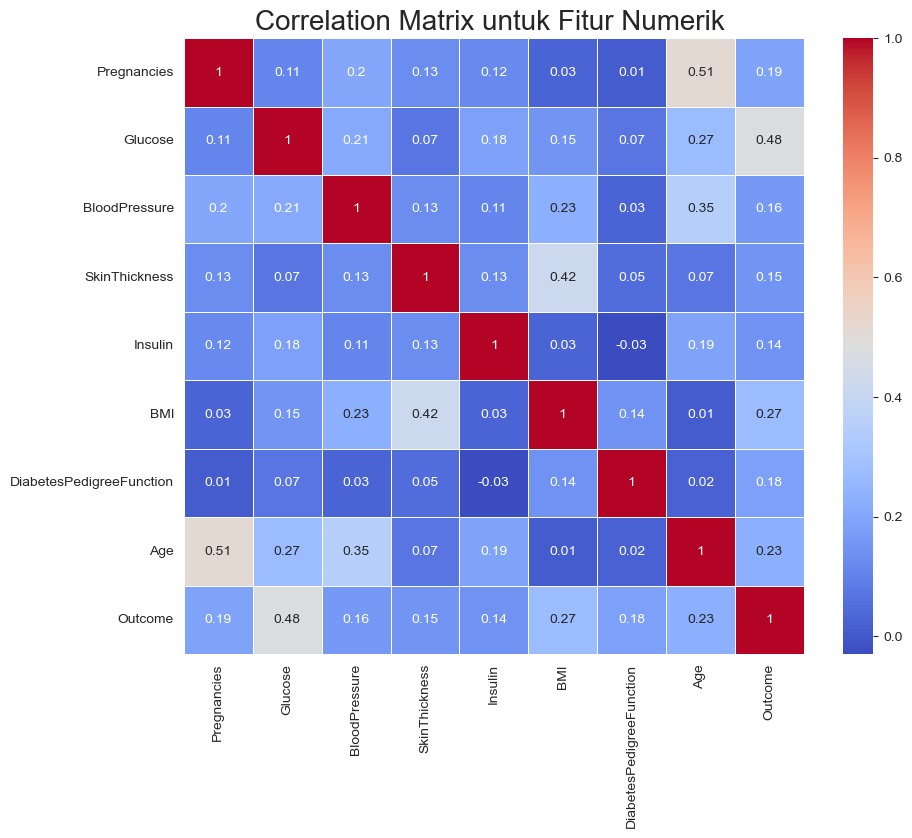

In [52]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr().round(2)

sns.heatmap(
    data=correlation_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
)
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

### Data preprocessing

-   Over sampling dengan metode SMOTE
-   Split data menjadi 80% data latih dan 20% data uji
-   Scaling data dengan StandardScaler


In [81]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [82]:
df["Outcome"].value_counts()

0    336
1    179
Name: Outcome, dtype: int64

In [96]:
smote = SMOTE(k_neighbors=3, random_state=2024, n_jobs=-1)
X_over, y_over = smote.fit_resample(X, y)

c:\Users\hp\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [97]:
y_over.value_counts()

1    336
0    336
Name: Outcome, dtype: int64

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X_over, y_over, test_size=0.2, random_state=2024
)

In [99]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Modeling

-   Data akan dilatih pada 3 jenis model yang berbeda yaitu KNN, Random Forest, dan SVM. Cross validation dengan split = 5 digunakan untuk melatih model dengan metrik evaluasi yang digunakan adalah f1 score. Model dengan hasil rata-rata cross validation dan hasil data uji terbaik akan digunakan sebagai baseline model.
-   Model terbaik akan dilakukan hyperparameter tuning dan diterapkan cross validation dengan split = 5. Metrik evaluasi yang digunakan adalah f1 score. Model dengan nilai f1 score terbesar akan dianggap sebagai model terbaik.


In [103]:
models = {
    "knn": KNeighborsClassifier(),
    "random_forest": RandomForestClassifier(),
    "svm": SVC(),
}

In [105]:
model_results = pd.DataFrame(
    index=models.keys(), columns=["train", "validation", "test"]
)

In [111]:
for name, model in models.items():
    results = cross_validate(
        model,
        X_train,
        y_train,
        scoring="f1",
        cv=5,
        n_jobs=-1,
        verbose=1,
        return_train_score=True,
    )

    model.fit(X_train, y_train)

    model_results.loc[name, "train"] = np.mean(results["train_score"])
    model_results.loc[name, "validation"] = np.mean(results["test_score"])
    model_results.loc[name, "test"] = f1_score(y_test, model.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
c:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [112]:
model_results

,train,validation,test
knn,0.848135,0.766873,0.778523
random_forest,1.0,0.797179,0.827068
svm,0.848628,0.778513,0.826087


### Hyperparameter tuning

-   Hasil model terbaik yang didapat adalah Random Forest, sehingga akan dilakukan tuning dengan hyperparameter sebagai berikut:
    -   n_estimators: [100, 200, 400]
    -   max_depth: [16, 32]
    -   min_samples_split: [2, 5]
    -   ccp_alpha: [0.001, 0.005, 0.007]


In [118]:
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [16, 32],
    "min_samples_split": [2, 5],
    "ccp_alpha": [0.001, 0.005, 0.007],
}

In [119]:
baseline = RandomForestClassifier(random_state=2024, n_jobs=-1)
grid = GridSearchCV(
    baseline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="f1",
    verbose=1,
    return_train_score=True,
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=2024),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.001, 0.005, 0.007],
                         'max_depth': [16, 32], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 400]},
             return_train_score=True, scoring='f1', verbose=1)

In [120]:
grid.best_params_

{'ccp_alpha': 0.001,
 'max_depth': 16,
 'min_samples_split': 2,
 'n_estimators': 400}

In [125]:
results = pd.DataFrame(grid.cv_results_)

results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.284120,0.010911,0.039311,0.000820,0.001,16,2,100,"{'ccp_alpha': 0.001, 'max_depth': 16, 'min_sam...",0.800000,...,0.792979,0.042759,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.657130,0.070144,0.080497,0.010291,0.001,16,2,200,"{'ccp_alpha': 0.001, 'max_depth': 16, 'min_sam...",0.807339,...,0.798217,0.045741,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,1.471508,0.051244,0.116495,0.006386,0.001,16,2,400,"{'ccp_alpha': 0.001, 'max_depth': 16, 'min_sam...",0.818182,...,0.798240,0.045047,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.338007,0.018006,0.053827,0.015554,0.001,16,5,100,"{'ccp_alpha': 0.001, 'max_depth': 16, 'min_sam...",0.756757,...,0.780109,0.037736,21,0.988558,0.995413,0.993135,1.000000,0.995413,0.994504,0.003717
4,0.894278,0.093533,0.066713,0.003324,0.001,16,5,200,"{'ccp_alpha': 0.001, 'max_depth': 16, 'min_sam...",0.763636,...,0.783872,0.043382,8,0.995392,0.995392,0.990868,1.000000,0.997712,0.995873,0.003031
5,1.533665,0.071329,0.125173,0.010138,0.001,16,5,400,"{'ccp_alpha': 0.001, 'max_depth': 16, 'min_sam...",0.770642,...,0.783375,0.040514,9,0.995392,0.993103,0.993166,1.000000,0.997712,0.995875,0.002670
6,0.376776,0.041006,0.046354,0.005207,0.001,32,2,100,"{'ccp_alpha': 0.001, 'max_depth': 32, 'min_sam...",0.800000,...,0.791530,0.040717,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,0.798457,0.105581,0.070942,0.005745,0.001,32,2,200,"{'ccp_alpha': 0.001, 'max_depth': 32, 'min_sam...",0.807339,...,0.796851,0.039699,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,1.596112,0.155425,0.151042,0.062188,0.001,32,2,400,"{'ccp_alpha': 0.001, 'max_depth': 32, 'min_sam...",0.810811,...,0.794617,0.044709,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,0.348803,0.008612,0.045875,0.006440,0.001,32,5,100,"{'ccp_alpha': 0.001, 'max_depth': 32, 'min_sam...",0.756757,...,0.777783,0.041496,23,0.993103,0.995413,0.993135,1.000000,0.995413,0.995413,0.002513


### Evaluation

Hasil hyperparameter tuning pada RandomForestClassifier menghasilkan model terbaik dengan hyperparameter sebagai berikut:

-   n_estimators: 400
-   max_depth: 16
-   min_samples_split: 2
-   ccp_alpha: 0.001

Model akan dievaluasi pada test set untuk memastikan bahwa model tidak overfit, dan dapat memprediksi data yang belum pernah dilihat secara akurat. Terdapat 4 metrik evaluasi yang digunakan:

-   $ Accuracy = \frac{(TP+TN)}{(TP+TN+FN+FP)} $

-   $ Precision = \frac{TP}{(TP+FP)} $

-   $ Recall = \frac{TP}{(TP+FN)} $

-   $ F1 = \frac{(2*precision*recall)}{(precision+recall)} $

Keterangan:

-   TP (True Positive) = Prediksi 1, Ground Truth 1
-   TN (True Negative) = Prediksi 0, Ground Truth 0
-   FP (False Positive) = Prediksi 1, Ground Truth 0
-   FN (False Negative) = Prediksi 0, Ground Truth 1

Model terbaik menghasilkan hasil sebagai berikut:

-   Accuracy: 86%
-   Recall: 91%
-   Precision: 82%
-   F1: 86%


In [126]:
best_estimator = grid.best_estimator_

best_estimator.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.001, max_depth=16, n_estimators=400,
                       n_jobs=-1, random_state=2024)

In [127]:
y_pred = best_estimator.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        71
           1       0.82      0.91      0.86        64

    accuracy                           0.86       135
   macro avg       0.86      0.86      0.86       135
weighted avg       0.86      0.86      0.86       135



In [129]:
final_result = pd.DataFrame(
    {
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
    },
    index=["RandomForest"],
)

final_result.round(2)

,accuracy,recall,precision,f1
RandomForest,0.86,0.91,0.82,0.86
